In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby
import scipy

In [3]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR

from statsmodels.iolib.summary2 import summary_col


In [90]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

from src.utils import get_statsmodels_tab

# load data

In [5]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)

topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [75]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_exp_MY', 'i_exp_MY', 'pi_exp_WY'
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[['pi_exp_MY', 'i_exp_MY', 'pi_exp_WY']].drop_duplicates().add_suffix("_F"),],
                 index_name='date_recorded')

In [76]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df = df.reset_index(drop=True)

In [77]:
# check

In [78]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

# plot data

<AxesSubplot: xlabel='M'>

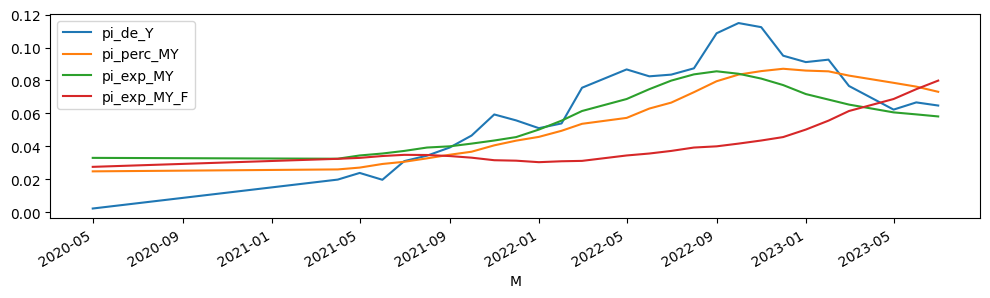

In [79]:
pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_perc_MY', 'pi_exp_MY', 'pi_exp_MY_F'],
           "M", 'last').dropna().plot()

# Expectation and perception

In [80]:
# get pi percption error
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=7)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=3)

In [81]:
lst_error_cols = [
    'pi_exp_MY_error_mse',
    'pi_perc_MY_error_mse',
    'pi_perc_MY_all_error_mse',
    'pi_perc_MY_all_error_act', 
]

## Perception error: What explains the perception error in the cross-section

In [82]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

pi_exp_MY_error_mse (15016, 2)
pi_perc_MY_error_mse (7629, 2)
pi_perc_MY_all_error_mse (22478, 2)
pi_perc_MY_all_error_act (22478, 2)


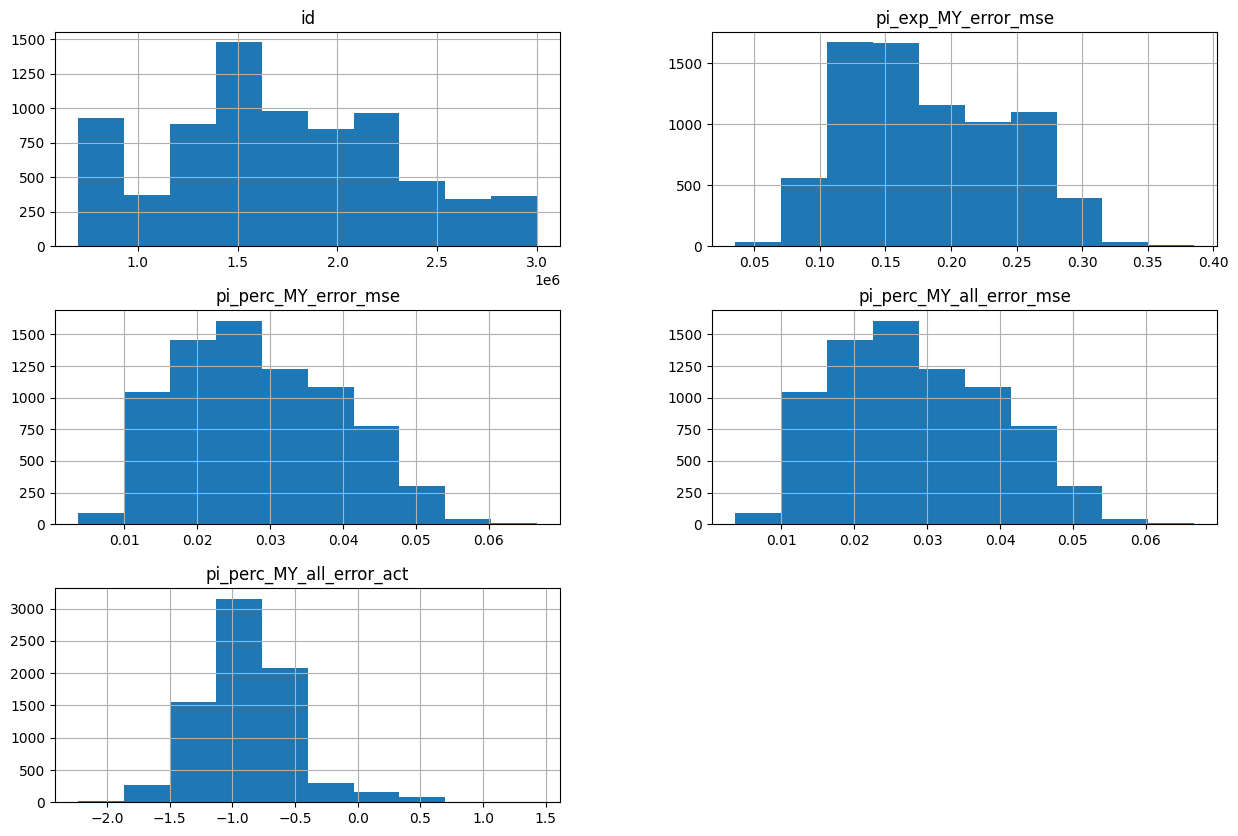

In [83]:
df[['id', *lst_error_cols]].drop_duplicates().dropna().hist(figsize=(15,10));

In [84]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
sub = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'debt_midpoint',
        # 'wealth_bank_midpoint', 
        'savings_planned', 
        'profession_txt',
        # 'pr
        # 'hhsize',
        'hhchildren', 
        'is_invest_shop', 
        'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
sub = sub.join(_).reset_index().groupby('id').last()

In [85]:
DICT_PARSE_COLS.update({'hhsize': 'category', 'profession_txt': 'category', 'savings_planned': int})
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
sub = pd_df_astype(sub, DICT_PARSE_COLS)

In [86]:
ols_data = sub.copy()
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col], prefix=col)
        # dummies.columns = [i.split(' ')[0] for i in dummies.columns]
        ols_data = ols_data.join(dummies.iloc[:, :-1])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [87]:
# fig = sns.heatmap(np.tril(ols_data.drop('const', axis=1).corr().abs(), k=-1), 
#                   xticklabels=ols_data.columns[:-1],
#                   cmap='winter', vmin=0, vmax=.8);

In [88]:
# multiple ols models
lst_ols_mods = []
for col in lst_error_cols:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    d = d.dropna()
    print(d.shape)
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    lst_ols_mods.append(ols)

(5088, 17)
(1785, 17)
(6024, 17)
(6024, 17)


In [89]:
summary_col(lst_ols_mods, stars=True)

,pi_exp_MY_error_mse,pi_perc_MY_error_mse,pi_perc_MY_all_error_mse,pi_perc_MY_all_error_act
is_food_shop,-0.0128***,-0.0029**,-0.0034***,-0.1165***
,(0.0050),(0.0012),(0.0009),(0.0429)
hhinc_midpoint,0.0000**,-0.0000,-0.0000**,-0.0000**
,(0.0000),(0.0000),(0.0000),(0.0000)
savings_planned,0.0005,0.0008,-0.0002,0.0303*
,(0.0021),(0.0005),(0.0004),(0.0179)
is_invest_shop,-0.0030,-0.0028,-0.0024,0.0810
,(0.0111),(0.0033),(0.0021),(0.1003)
is_unempl,0.0351***,0.0014,-0.0033,-0.0794
,(0.0109),(0.0038),(0.0021),(0.0963)


In [91]:
x = get_statsmodels_tab(lst_ols_mods)
save_pd_df(x[3], 'text.csv', GRAPHS_DIR)

## VAR: Is the aggregated perception error systematic ?

In [ ]:
sub = pd_join_freq(
    hhp.set_index('date_recorded')[['pi_perc_MY', 'delta_pe_MY']].drop_duplicates(), 
    pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
    'M', keep_left_index=False).drop_duplicates()
sub['pi_perc_err'] = sub.pi_de_Y - sub.pi_perc_MY

<AxesSubplot: xlabel='M'>

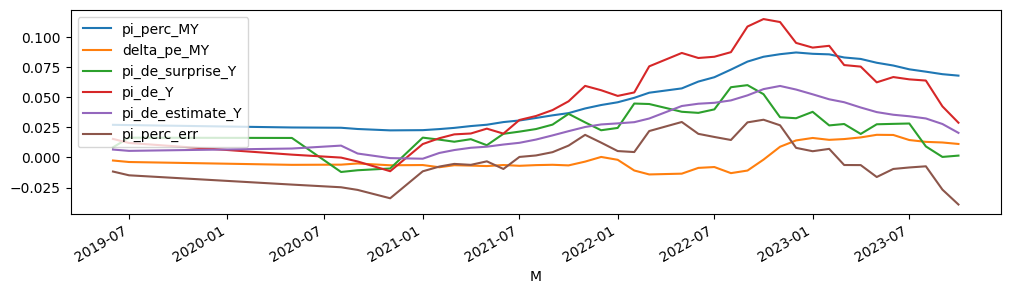

In [ ]:
sub.dropna().plot()

In [162]:
from src.utils import get_stars

In [232]:
def get_statsmodels_var_summary(var, col_name: int = 1, **kwargs):
    summary = pd.DataFrame(var.pvalues.stack(), columns=['pval'])
    summary['coef'] = np.concatenate([np.ones(var.neqs), var.coefs.ravel()])
    summary['stder'] = var.stderr.unstack().values
    summary['stars'] = summary.pval.map(get_stars)
    
    lst_txt = []
    for i, row in summary.round(3).iterrows():
        lst_txt.append( f"{row['coef']}{row['stars']}\n[{row['stder']}]" )
    summary['txt'] = lst_txt
    
    columns = [(col_name, i) for i in summary.columns]
    summary.columns = pd.MultiIndex.from_tuples(columns)
    
    return summary

def get_statmodels_var_summary_joint(lst_of_vars, lst_of_names = None, **kwargs):
    if lst_of_names is None:
        lst_of_names = [*range(len(lst_of_vars))]
    lst_summaries = [get_statsmodels_var_summary(var, col_name=lst_of_names[i]) for i, var in enumerate(lst_of_vars)]
    df = lst_summaries[0]
    for i, summary in enumerate(lst_summaries[1:]):
        df = df.join(summary, how='outer')
    
    
    return df

Interestingly suprise inflation of lag1 drives expectation error most

In [263]:
cols_endog, cols_exog = ['pi_perc_err'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit()
print(var1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Mar, 2024
Time:                     15:58:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -31.0155
Nobs:                     37.0000    HQIC:                  -31.3537
Log likelihood:           437.949    FPE:                2.01540e-14
AIC:                     -31.5379    Det(Omega_mle):     1.48120e-14
--------------------------------------------------------------------
Results for equation pi_perc_err
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.000756         0.001122           -0.674           0.500
L1.pi_perc_err             -0.075232         0.143051           -0.526           0.599
L1.pi_de_surprise_Y         0.

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


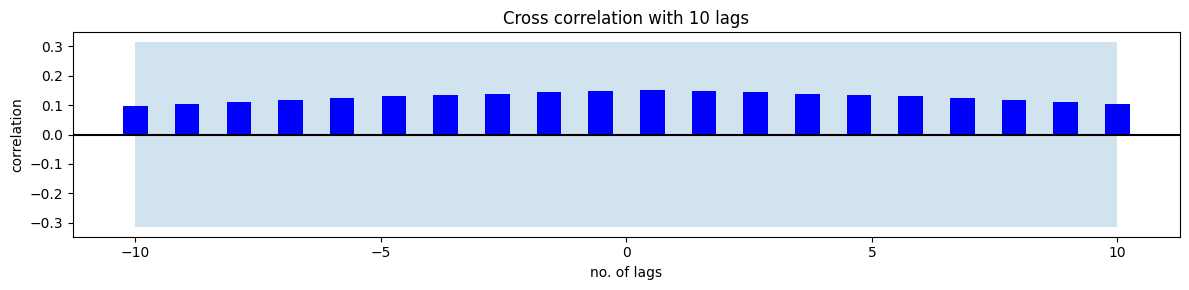

In [249]:
cross_corr(sub.pi_perc_MY, sub.pi_de_Y);

## Delta exp - perc: aggregate analysis

In [250]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var2 = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [262]:
x = get_statmodels_var_summary_joint([var1, var2])
# save_pd_df(x, 'var.csv', GRAPHS_DIR)
x.swaplevel(axis=1)[['coef', 'stars',]].swaplevel(axis=1).sort_index(axis=1)

0               1      
                                          coef stars      coef stars
L1.delta_pe_MY      delta_pe_MY            NaN   NaN  0.748582   ***
                    pi_de_estimate_Y       NaN   NaN  0.232418      
                    pi_de_surprise_Y       NaN   NaN -0.000520      
L1.pi_de_estimate_Y delta_pe_MY            NaN   NaN  0.110489      
                    pi_de_estimate_Y  0.536601   ***  0.188924      
                    pi_de_surprise_Y  0.171882        0.208389      
                    pi_perc_err       0.143688             NaN   NaN
L1.pi_de_surprise_Y delta_pe_MY            NaN   NaN -0.877037      
                    pi_de_estimate_Y -0.356367   *** -0.284871   ***
                    pi_de_surprise_Y  0.069451       -0.027216      
                    pi_perc_err      -0.153563   ***       NaN   NaN
L1.pi_perc_err      pi_de_estimate_Y  0.357467   ***       NaN   NaN
                    pi_de_surprise_Y  0.622986             NaN   NaN
                    pi_perc_err      -0.075232             NaN   NaN
L2.delta_pe_MY      delta_pe_MY            NaN   NaN -0.333832    **
                    pi_de_estimate_Y       NaN   NaN -0.143086     *
                    pi_de_surprise_Y       NaN   NaN  0.067796      
L2.pi_de_estimate_Y delta_pe_MY            NaN   NaN -0.187490      
                    pi_de_estimate_Y       NaN   NaN  0.331980   ***
                    pi_de_surprise_Y       NaN   NaN  0.177470      
L2.pi_de_surprise_Y delta_pe_MY            NaN   NaN  0.962737      
                    pi_de_estimate_Y       NaN   NaN  0.409300   ***
                    pi_de_surprise_Y       NaN   NaN -0.096577      
const               delta_pe_MY            NaN   NaN  1.000000      
                    pi_de_estimate_Y  1.000000        1.000000      
                    pi_de_surprise_Y  1.000000        1.000000      
                    pi_perc_err       1.000000             NaN   NaN

# News analysis

## overview on news and narratives

In [107]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

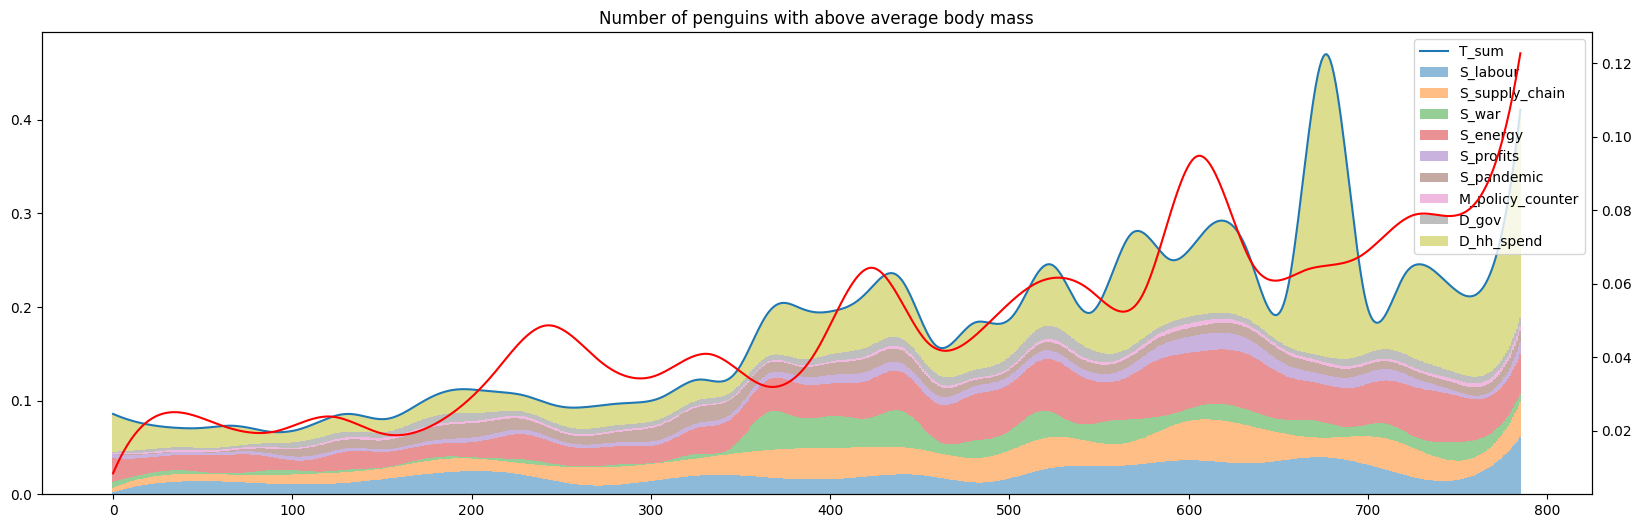

In [108]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1))

ax.plot(sub.T_sum.values, label='T_sum')
ax.twinx().plot(sub.D_inflation.values, color='red', label='D_inflation')
ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right");

''

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


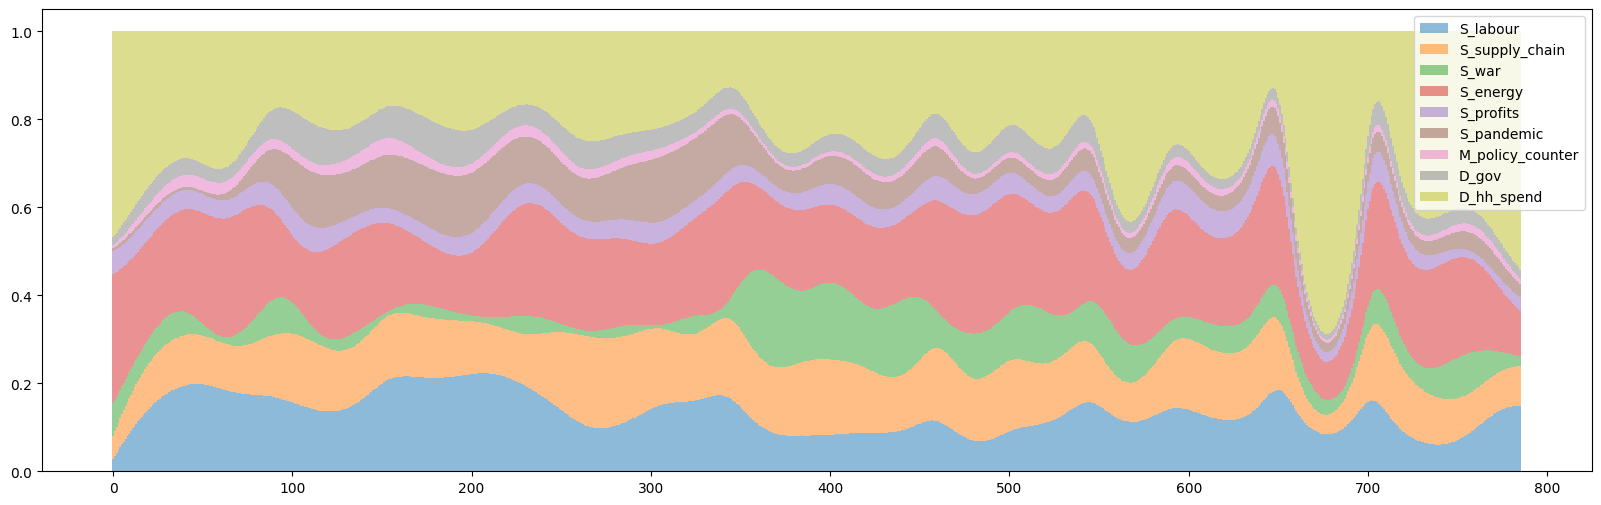

In [109]:
fig, ax = plt_stacked_bar(
    sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
)
ax.legend()
;

## PCA

In [110]:
X = topics_raw.drop(['D_inflation'], axis=1).diff().copy().dropna()
X = topics.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).diff().copy().dropna()

scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), X.index, X.columns)
pca = PCA(n_components=5).fit(X_std)

In [111]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

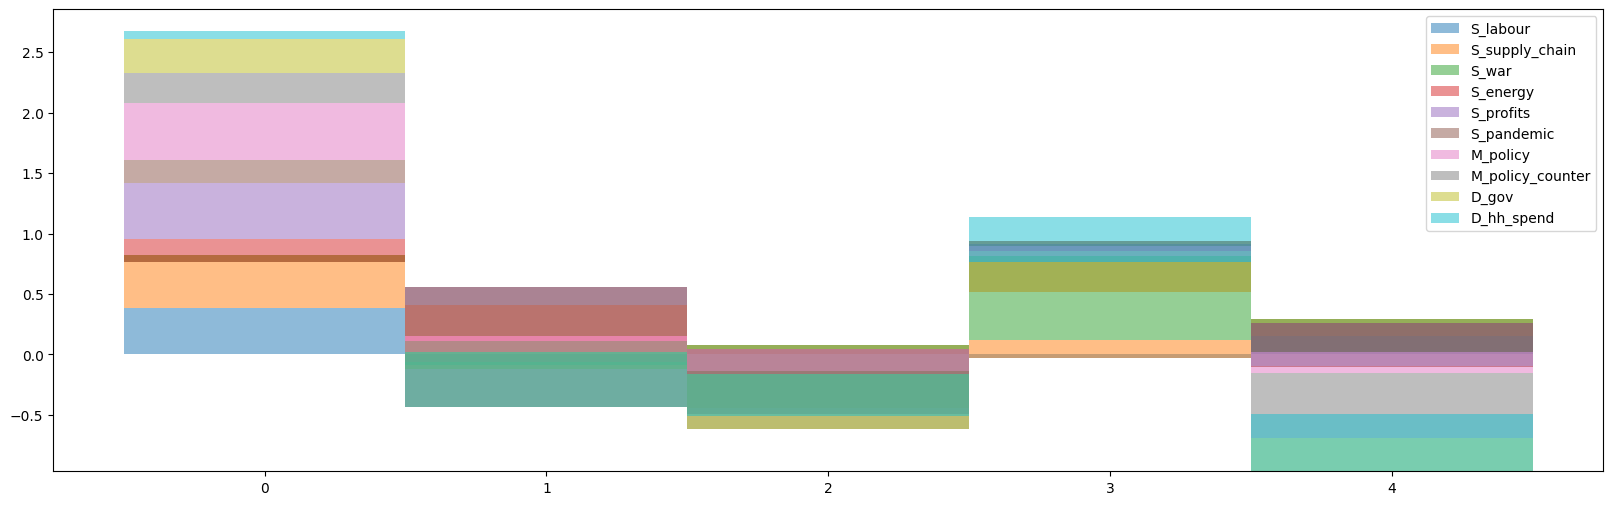

In [112]:
fig, ax = plt_stacked_bar(pd.DataFrame(pca.components_, columns = X.columns))
ax.legend(X.columns)

Text(0.5, 1.0, 'Components across time')

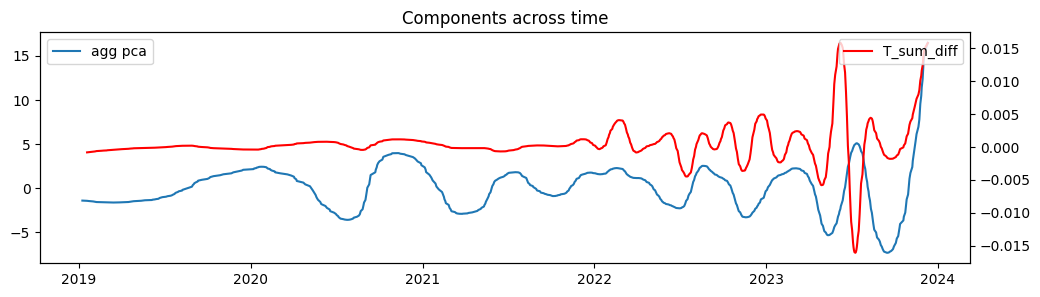

In [113]:
fig, ax = plt.subplots()

ax.plot(X.index, (pca.components_ @ X_std.T).T.sum(axis=1), label='agg pca');
ax2 = ax.twinx()
ax2.plot(topics.T_sum_diff_lag.dropna(), color='red', label='T_sum_diff')
ax.legend()
ax2.legend(loc='upper right')
plt.title('Components across time')

In [114]:
topics = topics.join(pd.Series((pca.components_ @ X_std.T).T.sum(axis=1), index=X.index, name='T_pca_sum_diff'))
topics['T_pca_sum'] = topics.T_pca_sum_diff.cumsum()

In [115]:
df = pd_join_freq(
    df.set_index('date_recorded'), 
    topics[['T_pca_sum_diff', 'T_pca_sum']].apply(lambda x: (x - x.min())/(x.max() - x.min())).copy(),
    'W', True)

df = df.reset_index(drop=True)

## war and inflation as given by hh concern

In [116]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

In [117]:
# for col in sub:
#     adf_test_summary(sub[col])

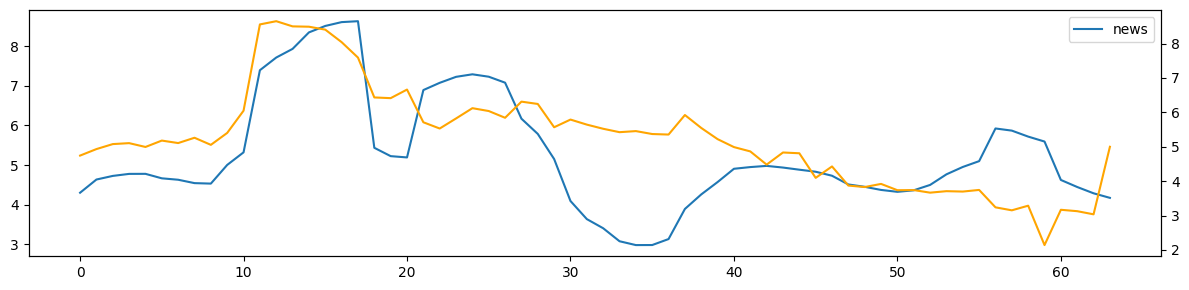

In [118]:
fig, ax = plt.subplots(1,1)
ax.plot(sub.S_pandemic.values, label='news')
ax.twinx().plot(sub.percprob_covid.values, color='orange')
ax.legend(['news', 'perceived'])
ax.legend()
plt.tight_layout()

In [119]:
select_coint_rank(sub[['S_pandemic', 'percprob_covid']].dropna(), 1, 10).summary()

r_0,r_1,test statistic,critical value
0,2,26.60,18.40
1,2,9.246,3.841


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


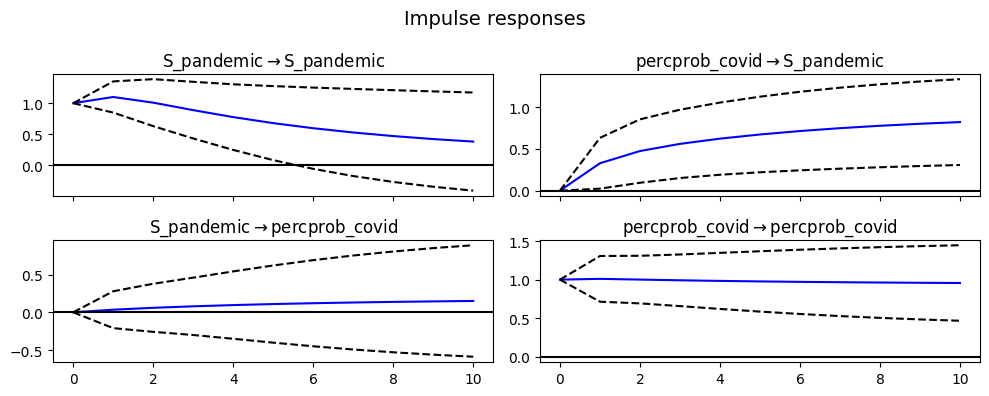

In [120]:
var = VECM(sub[['S_pandemic', 'percprob_covid']], coint_rank=1).fit()
var.irf().plot(figsize=(10,4))
plt.tight_layout(); 

# Macro analysis

## VECM: Does surprise inflation elicit higher news-paper reporting?

Following Dräger (2015) VECM to analyse:
$$ X_t = \Gamma X_{t-1} + u_t $$ 
where
$$X_t = (\pi_t, \pi^p_t, \pi^e_{t-12}, \Delta N_{t-1})$$

### with inflation monthly

(26, 4)

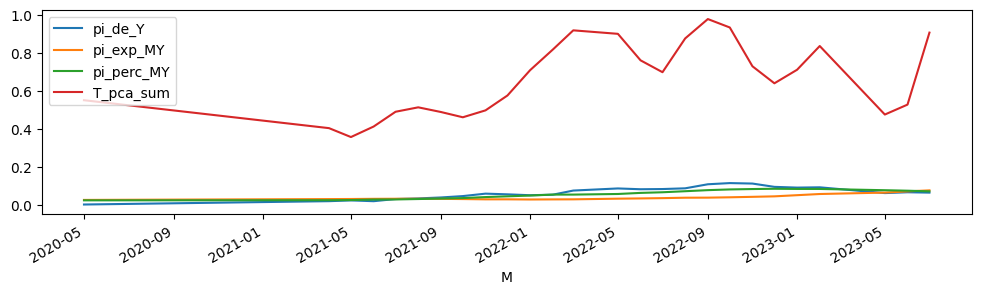

In [121]:
sub = pd_groupby(df.set_index('date_recorded'), ['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_pca_sum'], 'M', 'last').dropna()
sub.plot();
sub.shape

In [122]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_order(sub, maxlags=3) # signif=0.05)
jtest.summary()

pi_de_Y ADF p-val: 0.22268558157000867
pi_exp_MY ADF p-val: 1.0
pi_perc_MY ADF p-val: 0.2176634363900108
T_pca_sum ADF p-val: 0.003525326956052425


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

,AIC,BIC,FPE,HQIC
0,-39.39,-38.39,8.109e-18,-39.15
1,-39.77,-37.99,6.536e-18,-39.35
2,-40.71,-38.14,4.208e-18,-40.11
3,-44.05*,-40.68*,5.635e-19*,-43.26*


In [123]:
vecm = VECM(sub, coint_rank=jtest.aic).fit()
vecm.summary();

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


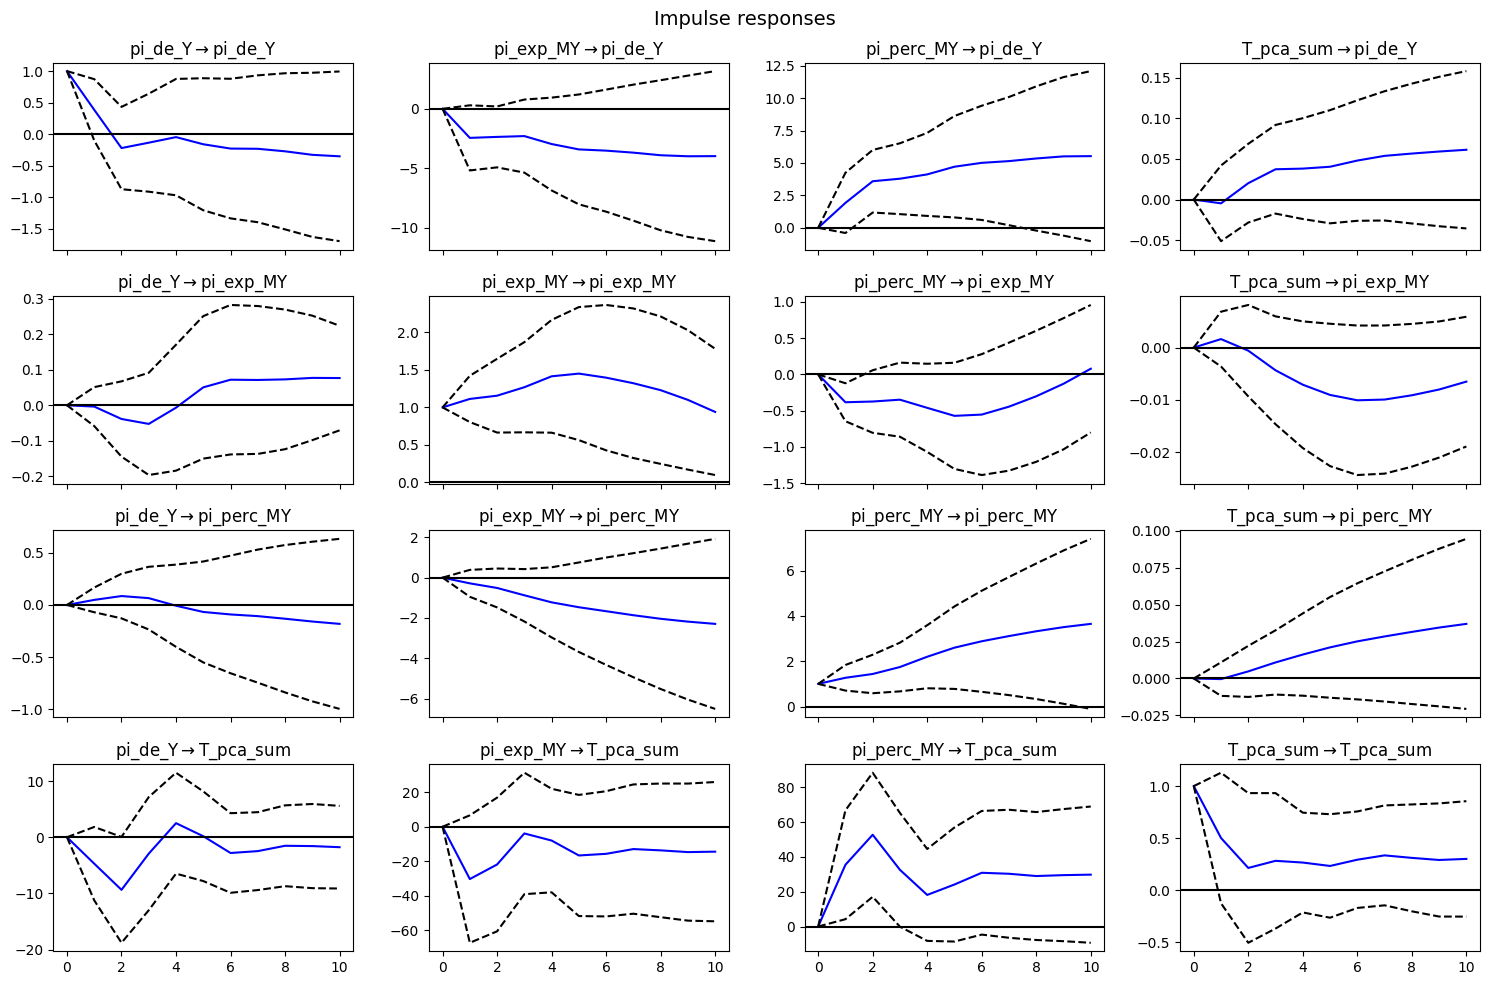

In [124]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

### without inflation

In [125]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'pi_perc_WY', 'T_pca_sum']].last().dropna()
sub.shape

(63, 3)

In [126]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_order(sub, maxlags=3) # signif=0.05)
jtest.summary()

pi_exp_WY ADF p-val: 0.991719157194337
pi_perc_WY ADF p-val: 0.1911300377251514
T_pca_sum ADF p-val: 0.33823473555607475


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

,AIC,BIC,FPE,HQIC
0,-34.25,-33.83,1.332e-15,-34.09
1,-34.59,-33.85*,9.566e-16,-34.30*
2,-34.68*,-33.63,8.745e-16*,-34.27
3,-34.56,-33.18,1.005e-15,-34.02


In [127]:
vecm = VECM(sub, coint_rank=jtest.aic).fit()
vecm.summary();

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


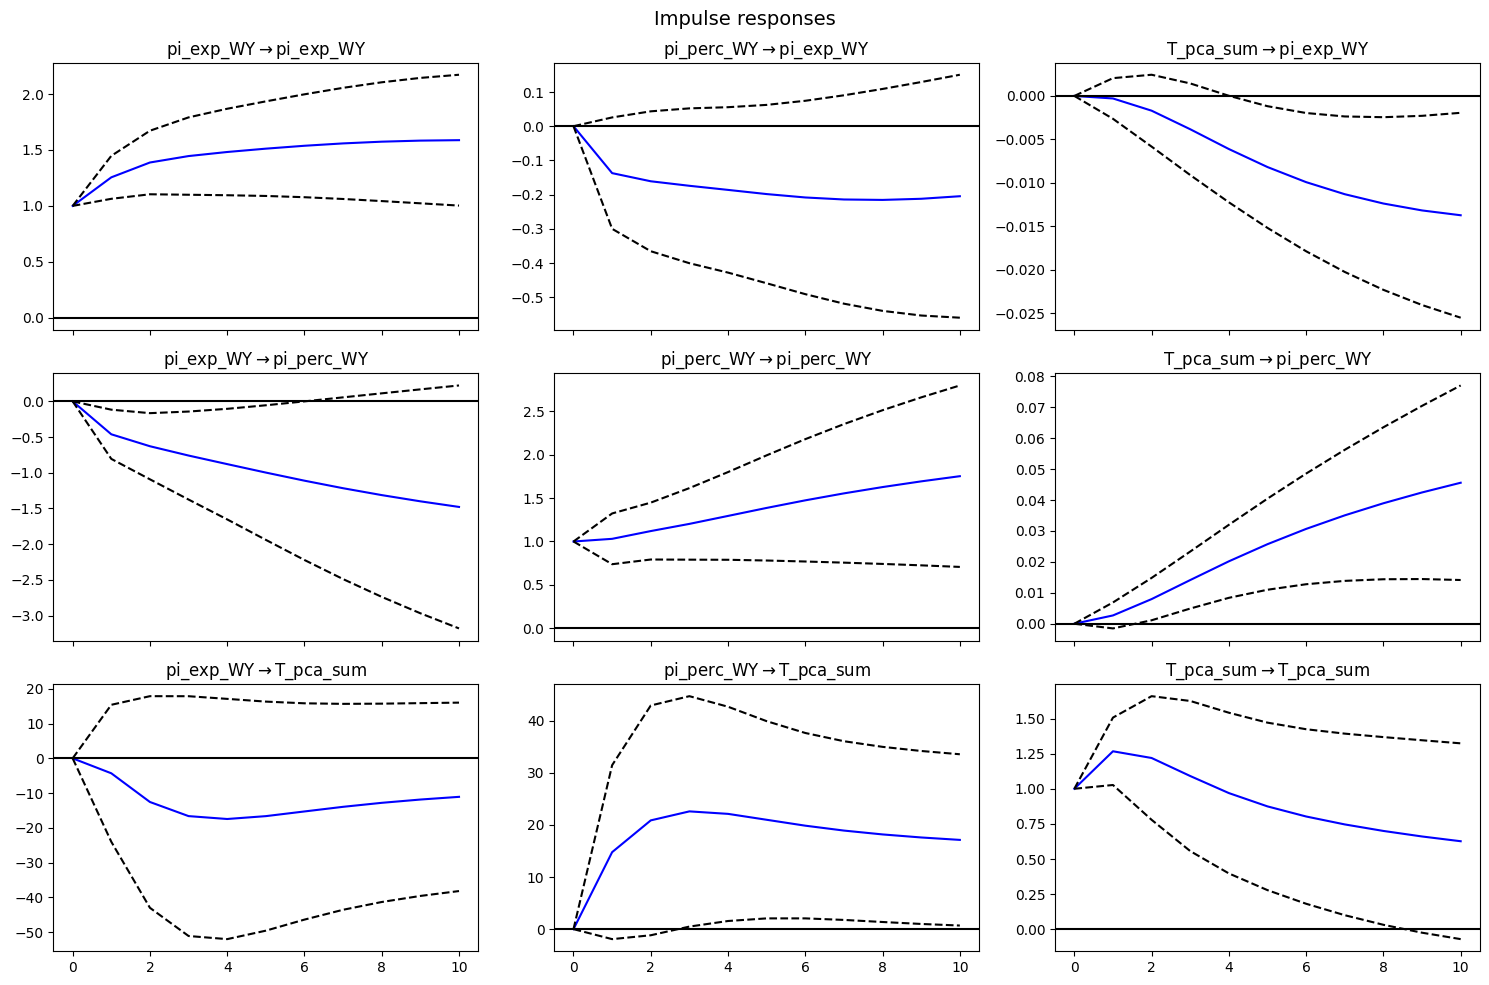

In [128]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

## VAR: Does surprise inflation elicit higher news-paper reporting?

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [129]:
sub = pd_groupby(df.set_index('date_recorded'), ['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_pca_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [130]:
var = VAR(sub_d).fit()
# var.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [131]:
# var.irf().plot()
# plt.tight_layout()

# Micro analysis

In [132]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y']],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_pca_sum', 'T_pca_sum_diff', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [133]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
    }
)

In [134]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [135]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [136]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
# dist = scipy.spatial.distance.cdist(dist, dist.mean(axis=0).values[None])
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

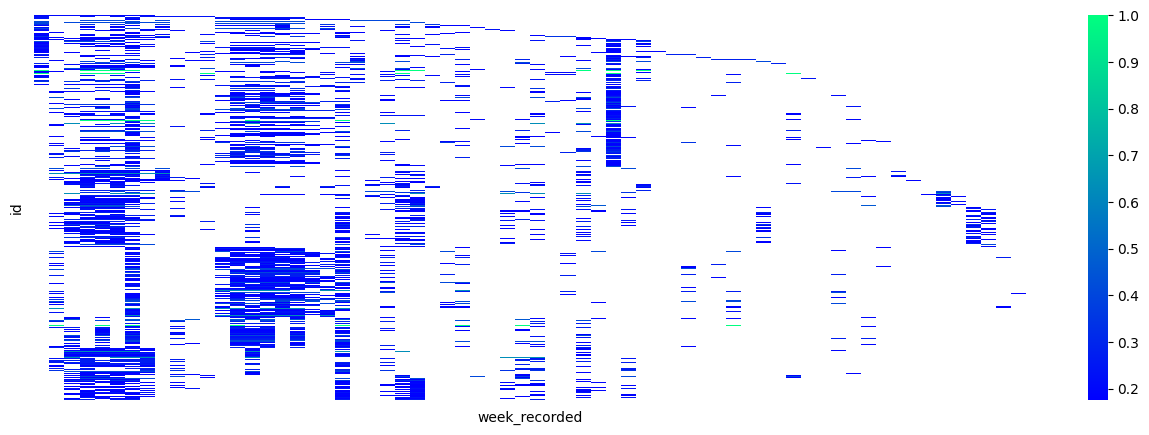

In [137]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [138]:
cols = ['T_pca_sum_diff', 'hhinc', 'pi_de_Y', 'is_unempl',] # 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [139]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [140]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.2847
Estimator:                   PanelOLS   R-squared (Between):              0.8198
No. Observations:                8055   R-squared (Within):               0.2847
Date:                Mon, Mar 18 2024   R-squared (Overall):              0.7679
Time:                        11:48:15   Log-likelihood                 2.024e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      173.73
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(15,6548)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             150.30
                            

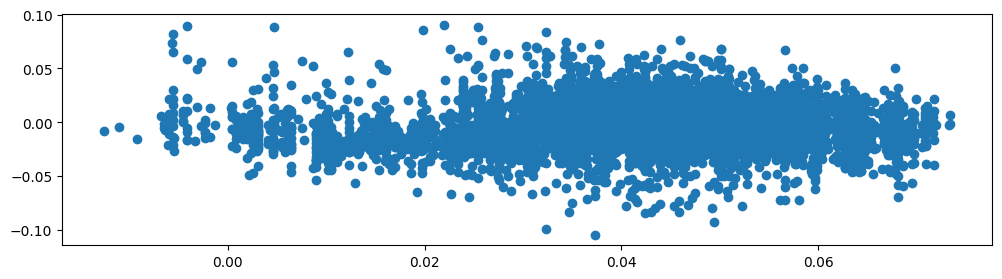

In [141]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [142]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 133.50717150815208, 'LM p-val': 6.921788807206553e-28, 'F-Stat': 33.91825107683774, 'F p-val': 4.122477238070524e-28}


In [143]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.0088812507320704


In [144]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 37.66878343322164
degrees of freedom: 15
p-Value: 0.0010097139106305258


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [145]:
cols = ['T_pca_sum_diff', 'hhinc_midpoint', 'pi_de_Y', 'debt', 'is_unempl', 'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [146]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 7), 715)

In [147]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.1280
Estimator:                   PanelOLS   R-squared (Between):             -2.0918
No. Observations:                2982   R-squared (Within):               0.1280
Date:                Mon, Mar 18 2024   R-squared (Overall):             -0.2780
Time:                        11:48:17   Log-likelihood                    9299.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.980
Entities:                         715   P-value                           0.0000
Avg Obs:                       4.1706   Distribution:                 F(22,2245)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             66.661
                            

In [148]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 664.6676767291964, 'LM p-val': 2.5940632914139204e-140, 'F-Stat': 142.21714615640255, 'F p-val': 6.807687272712243e-159}


In [149]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.216616757439626


In [150]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -0.5813582892901634
degrees of freedom: 22
p-Value: 1.0


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [151]:
cols = ['T_pca_sum_diff', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [152]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 4), 4300)

In [153]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4466
Estimator:                   PanelOLS   R-squared (Between):              0.8489
No. Observations:               29619   R-squared (Within):               0.4466
Date:                Mon, Mar 18 2024   R-squared (Overall):              0.8006
Time:                        11:48:18   Log-likelihood                  7.77e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6810.1
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                 F(3,25316)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             3962.8
                            

In [154]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 119.67335229441923, 'LM p-val': 9.073714175167188e-26, 'F-Stat': 40.04753928256069, 'F p-val': 8.102680197427338e-26}


In [155]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

1.9999634554570889


In [156]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 85.02987421636752
degrees of freedom: 3
p-Value: 2.5570758106111134e-18
